# Análise da Qualidade do Vinho Branco por meio de Algoritmos de Aprendizagem de Máquina

Este notebook tem como objetivo analisar os dados físico-químicos do vinho branco para predizer sua qualidade utilizando modelos de aprendizado de máquina. 
A seguir, o passo a passo da preparação dos dados, análise exploratória, transformação da variável target e a aplicação dos modelos.

In [1]:
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, accuracy_score
from xgboost import XGBRegressor, XGBClassifier

from scipy.stats import mannwhitneyu

## 1. Carregamento e Visualização dos Dados

In [2]:
wine_quality = fetch_ucirepo(id=186) 
   
df = pd.DataFrame(wine_quality.data['original'])
df = df[df["color"] == "white"]
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
1599,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1600,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
1601,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
1602,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
1603,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


## 2. Análise Exploratória de Dados

In [3]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [4]:
print(len(df[df["color"] == "red"]))
print(len(df[df["color"] == "white"]))

0
4898


### Distribuições das Variáveis Numéricas

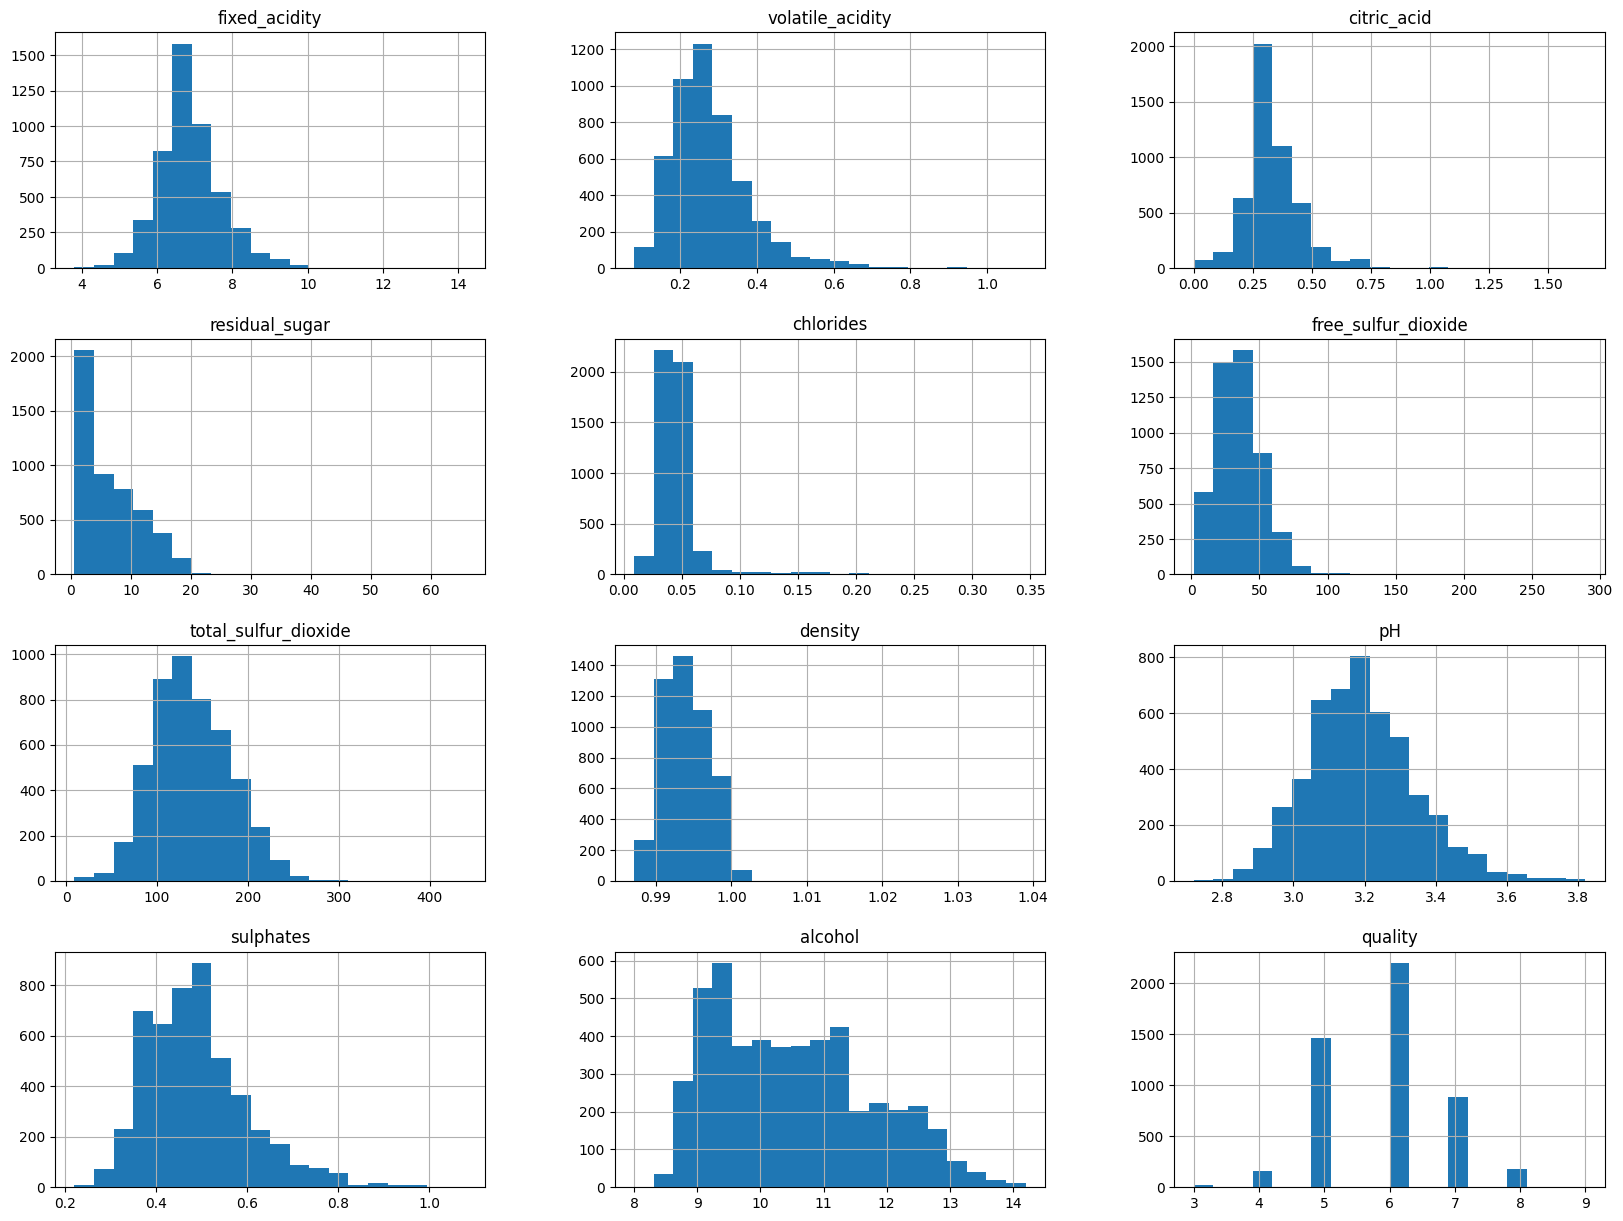

In [5]:
numeric_columns = df.select_dtypes(include=['float64', 'int']).columns

df[numeric_columns].hist(bins=20, figsize=(20, 15))
plt.show()

### Tratamento de Outliers

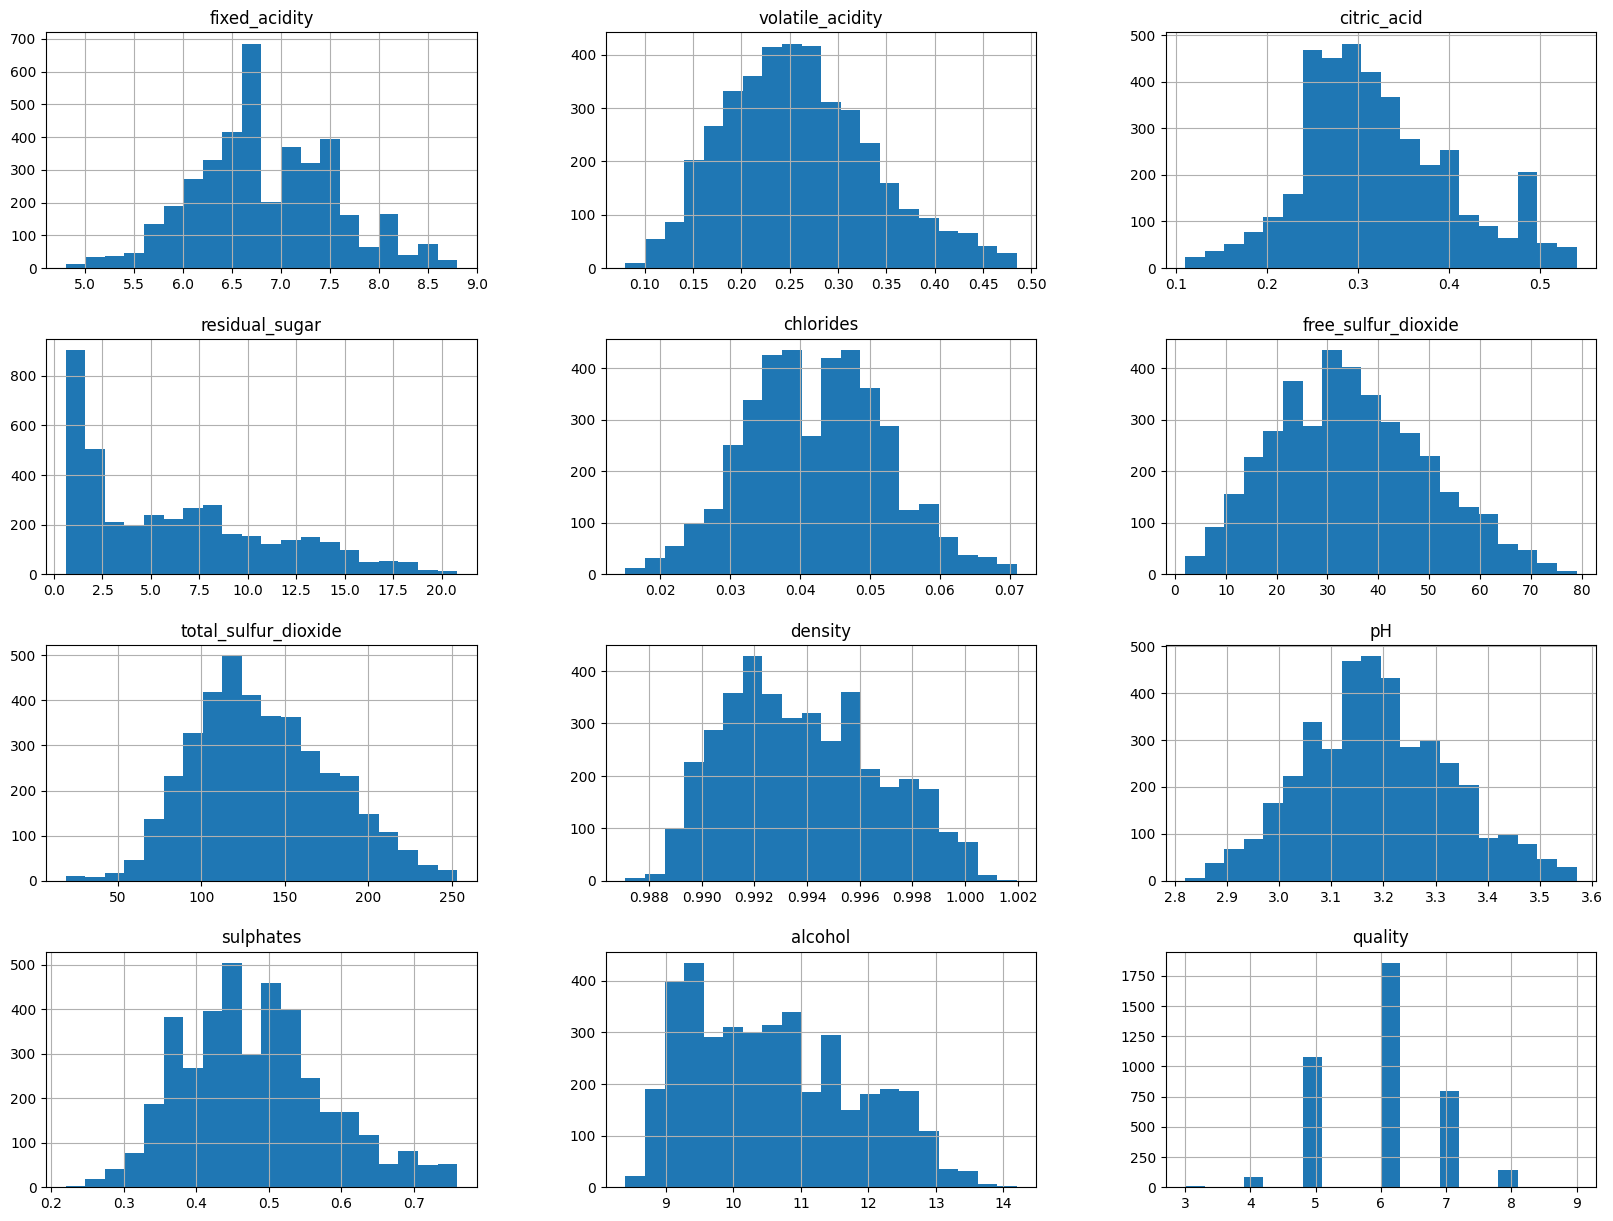

In [6]:
# Remover outliers usando o método IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]
    return df

numeric_columns_float = numeric_columns.to_list()
numeric_columns_float.remove('quality')

df = remove_outliers(df, numeric_columns_float)

df[numeric_columns].hist(bins=20, figsize=(20, 15))
plt.show()

In [7]:
print(len(df[df["color"] == "white"]))

3973


### Estatística Descritiva

In [8]:
# Calculando a assimetria
skewness = df[numeric_columns].skew()
print(skewness)

# Calculando a curtose
kurtosis = df[numeric_columns].kurt()
print(kurtosis)

fixed_acidity           0.162307
volatile_acidity        0.426053
citric_acid             0.395236
residual_sugar          0.738495
chlorides               0.083722
free_sulfur_dioxide     0.283531
total_sulfur_dioxide    0.300965
density                 0.296767
pH                      0.203653
sulphates               0.469108
alcohol                 0.380453
quality                 0.178296
dtype: float64
fixed_acidity          -0.164908
volatile_acidity       -0.139280
citric_acid            -0.070299
residual_sugar         -0.494102
chlorides              -0.262746
free_sulfur_dioxide    -0.437099
total_sulfur_dioxide   -0.343207
density                -0.781411
pH                     -0.223229
sulphates              -0.085747
alcohol                -0.806634
quality                 0.142347
dtype: float64


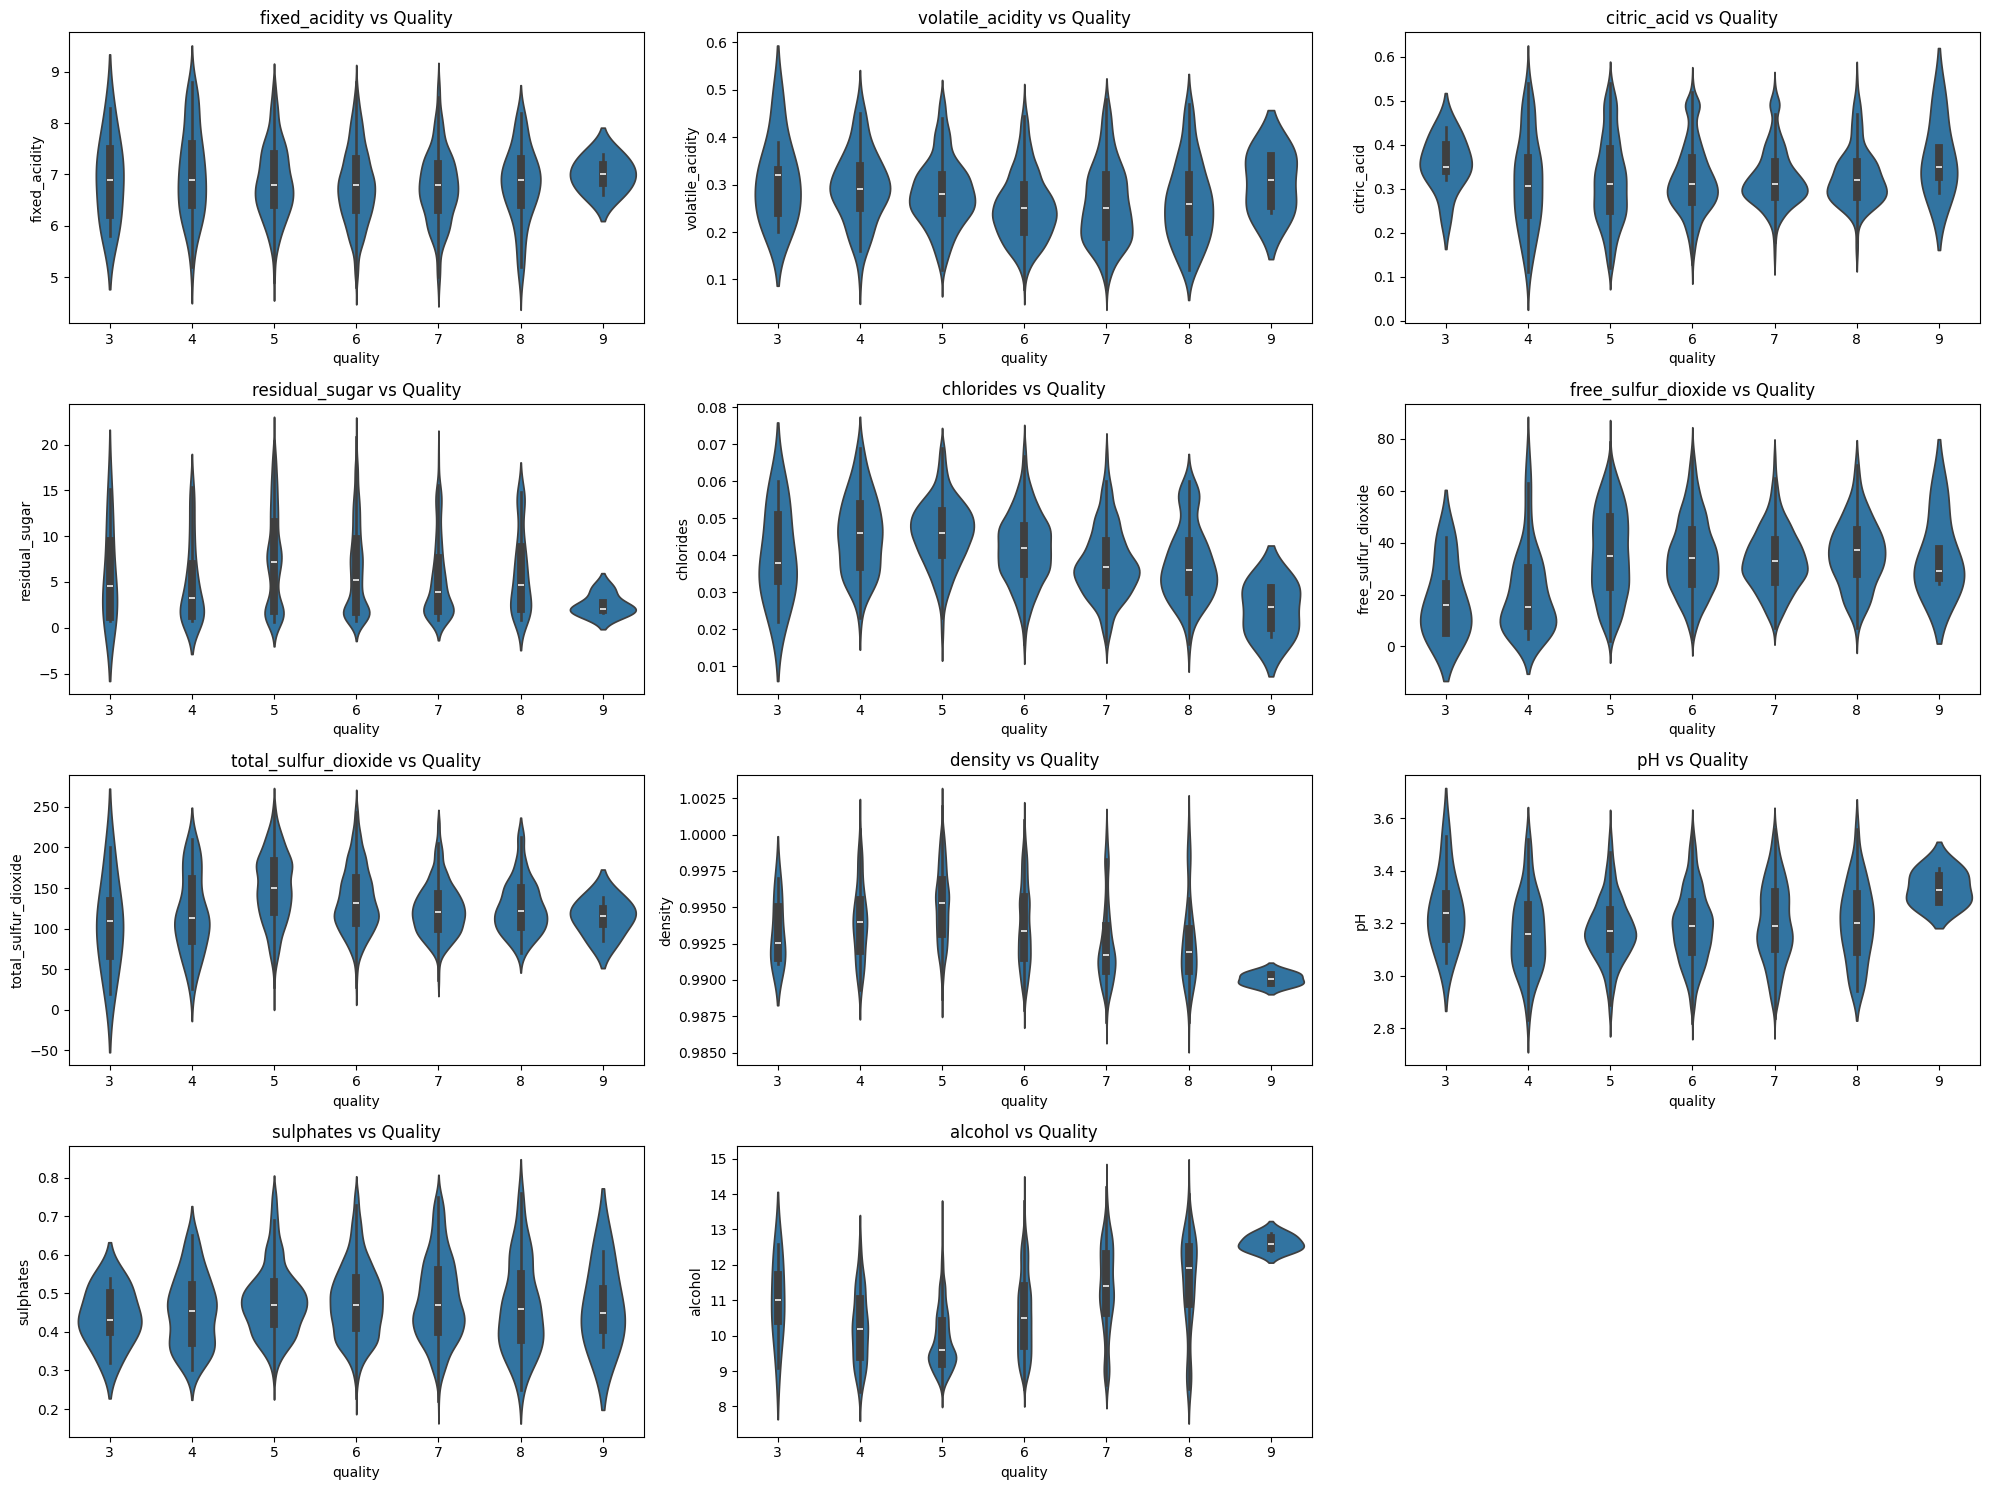

In [9]:
# Criar subplots para os gráficos de violino
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
axes = axes.flatten()

# Plotar um gráfico de violino para cada variável
for i, col in enumerate(numeric_columns_float):
    sns.violinplot(x='quality', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs Quality')

# Remover os subplots vazios, caso existam
for j in range(len(numeric_columns_float), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Estatística Diagnóstica

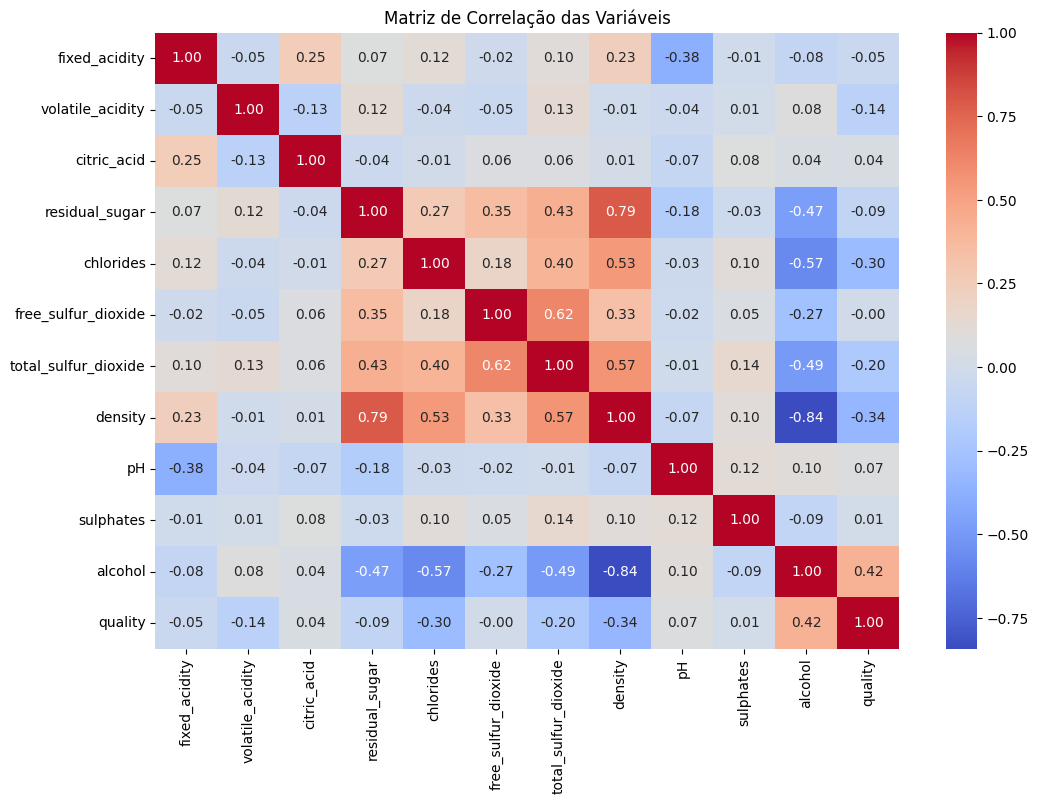

In [10]:
# Calcular a matriz de correlação
correlation_matrix = df[numeric_columns].corr(method='spearman')

# Plotar a matriz de correlação como um mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação das Variáveis')
plt.show()

### Quality categorical

In [11]:
# Criar a nova variável 'quality_cat' baseada no valor de 'quality'
df['quality_cat'] = df['quality'].apply(lambda x: 1 if x > 5 else 0)
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color,quality_cat
1599,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white,1
1600,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white,1
1601,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white,1
1602,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white,1
1603,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white,1


### Teste de Mann-Whitney

In [12]:
good_quality = df[df['quality_cat'] == 1]
bad_quality = df[df['quality_cat'] == 0]

# Aplicar o teste de Mann-Whitney para cada variável
for col in numeric_columns_float:
    stat, p_value = mannwhitneyu(good_quality[col], bad_quality[col])
    print(f'Teste Mann-Whitney para {col}: p-value = {p_value:.4f}')

Teste Mann-Whitney para fixed_acidity: p-value = 0.0021
Teste Mann-Whitney para volatile_acidity: p-value = 0.0000
Teste Mann-Whitney para citric_acid: p-value = 0.0470
Teste Mann-Whitney para residual_sugar: p-value = 0.0000
Teste Mann-Whitney para chlorides: p-value = 0.0000
Teste Mann-Whitney para free_sulfur_dioxide: p-value = 0.6976
Teste Mann-Whitney para total_sulfur_dioxide: p-value = 0.0000
Teste Mann-Whitney para density: p-value = 0.0000
Teste Mann-Whitney para pH: p-value = 0.0005
Teste Mann-Whitney para sulphates: p-value = 0.5247
Teste Mann-Whitney para alcohol: p-value = 0.0000


## 4. Treinamento dos modelos de regressão

In [13]:
selected_cols_reg = ['alcohol', 'density', 'chlorides', 'volatile_acidity', 'total_sulfur_dioxide']

X_reg = df[selected_cols_reg]
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X_reg, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[selected_cols_reg]), columns=selected_cols_reg)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[selected_cols_reg]), columns=selected_cols_reg)

In [14]:
# Função para treinar e avaliar um modelo
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return r2, mae, rmse

# Lista de modelos a serem testados
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "SVR": SVR(kernel='rbf')
}

# Avaliar cada modelo e armazenar os resultados
results = {}
for name, model in models.items():
    r2, mae, rmse = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    results[name] = {"R²": r2, "MAE": mae, "RMSE": rmse}

# Converter resultados para DataFrame para melhor visualização
results_df = pd.DataFrame(results).T
print(results_df)


                           R²       MAE      RMSE
Linear Regression    0.223987  0.595519  0.745120
Random Forest        0.469913  0.439283  0.615836
XGBoost              0.398642  0.473208  0.655931
K-Nearest Neighbors  0.228886  0.552704  0.742764
SVR                  0.309749  0.528455  0.702740


## 5. Treinamento dos modelos de classificação

In [15]:
selected_cols_cla = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
                    'chlorides', 'total_sulfur_dioxide', 'density', 'pH', 'alcohol']

X_cla = df[selected_cols_cla]
y = df['quality_cat']

X_train, X_test, y_train, y_test = train_test_split(X_cla, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[selected_cols_cla]), 
                              columns=selected_cols_cla)

X_test_scaled = pd.DataFrame(scaler.transform(X_test[selected_cols_cla]), 
                             columns=selected_cols_cla)

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss')  # Ajuste do XGBoost
}

def evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    return accuracy, report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']

results = {}
for model_name, model in models.items():
    accuracy, precision, recall, f1_score = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    }

results_df = pd.DataFrame(results).T
print(results_df)


                     Accuracy  Precision    Recall  F1-Score
Logistic Regression  0.758491   0.713552  0.637987  0.651144
Random Forest        0.845283   0.831839  0.774342  0.794909
SVM                  0.798742   0.780168  0.694855  0.716061
K-Nearest Neighbors  0.786164   0.742025  0.710722  0.722407
XGBoost              0.821384   0.792055  0.752357  0.767398
